In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import average_precision_for_user, f1_score
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [2]:
ALGORITHMS = ['cbf', 'mf', 'user-user', 'weight_uu_cbf_10','weight_uu_cbf_25', 'weight_uu_cbf_50', 'weight_uu_cbf_75', 'weight_uu_cbf_90', 'weight_uu_mf_10', 'weight_uu_mf_25', 'weight_uu_mf_50', 'weight_uu_mf_75', 'weight_uu_mf_90']

SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category', 'F1']

set_ratings(read_ratings_from_file())
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  f1_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(average_precision_for_user(top_n, user_id))
    f1_values.append(f1_score(top_n, user_id))
    rmse_predict = rmse_for_user(user_id, user_ratings, user_predictions)
    rmse_predict_values.append(rmse_predict)
    rmse_top_n = rmse_for_user(user_id, user_ratings, top_n)
    rmse_top_values.append(rmse_top_n)
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['F1'][algorithm] = calculate_statistics(f1_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['F1'] = pd.concat([results['F1'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

In [3]:
width = 12 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

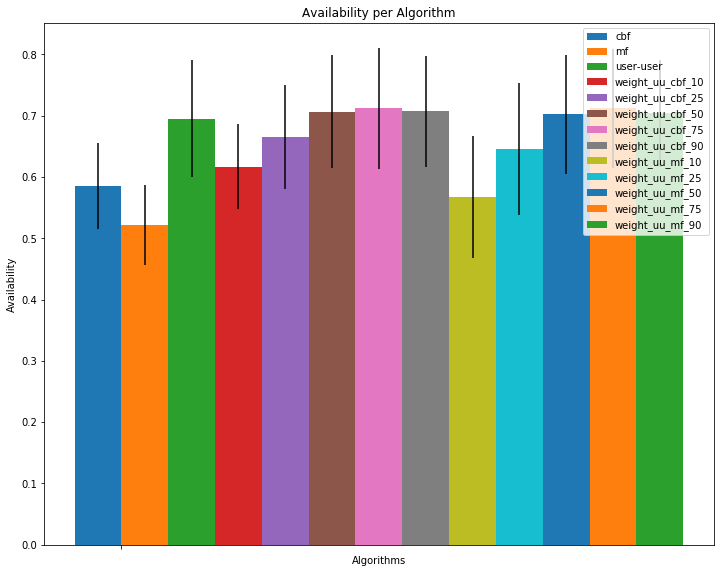

In [4]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [5]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.510899,0.532006,0.566868,0.623718,0.796855,0.802512,0.585363,0.480483,0.070753
mf,0.468187,0.468187,0.498603,0.564393,0.684572,0.684572,0.521616,0.468187,0.065243
user-user,0.567862,0.624114,0.688028,0.761760,0.908394,0.918805,0.695152,0.500692,0.094819
weight_uu_cbf_10,0.530289,0.566868,0.613450,0.655244,0.802516,0.802921,0.616843,0.491296,0.069233
weight_uu_cbf_25,0.556979,0.597995,0.662512,0.716371,0.852806,0.875896,0.664658,0.509416,0.084480
weight_uu_cbf_50,0.593129,0.641493,0.697951,0.772497,0.901577,0.922195,0.706369,0.448549,0.091717
weight_uu_cbf_75,0.587371,0.630986,0.704159,0.781949,0.950365,0.951731,0.711830,0.521712,0.098805
weight_uu_cbf_90,0.588601,0.629539,0.706475,0.775045,0.883685,0.893497,0.707021,0.515841,0.090170
weight_uu_mf_10,0.468187,0.481192,0.529781,0.637614,0.836897,0.854836,0.567068,0.465188,0.099929
weight_uu_mf_25,0.511555,0.562180,0.643129,0.731074,0.894254,0.908636,0.645503,0.468187,0.106909


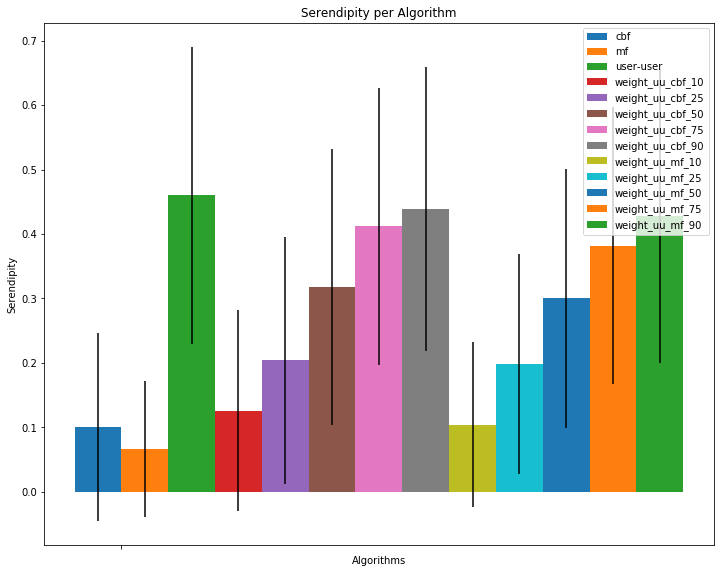

In [6]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [7]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.0,0.0,0.0,0.2,0.602,0.8,0.100,0.0,0.145602
mf,0.0,0.0,0.0,0.2,0.400,0.4,0.066,0.0,0.106038
user-user,0.2,0.2,0.4,0.6,0.802,1.0,0.460,0.0,0.230651
weight_uu_cbf_10,0.0,0.0,0.0,0.2,0.602,0.8,0.126,0.0,0.156601
weight_uu_cbf_25,0.0,0.0,0.2,0.4,0.602,0.8,0.204,0.0,0.191792
weight_uu_cbf_50,0.0,0.2,0.4,0.4,0.802,1.0,0.318,0.0,0.213719
weight_uu_cbf_75,0.2,0.2,0.4,0.6,0.802,1.0,0.412,0.0,0.215072
weight_uu_cbf_90,0.2,0.2,0.4,0.6,0.802,1.0,0.438,0.0,0.220354
weight_uu_mf_10,0.0,0.0,0.0,0.2,0.400,0.4,0.104,0.0,0.128000
weight_uu_mf_25,0.0,0.0,0.2,0.2,0.600,0.6,0.198,0.0,0.170868


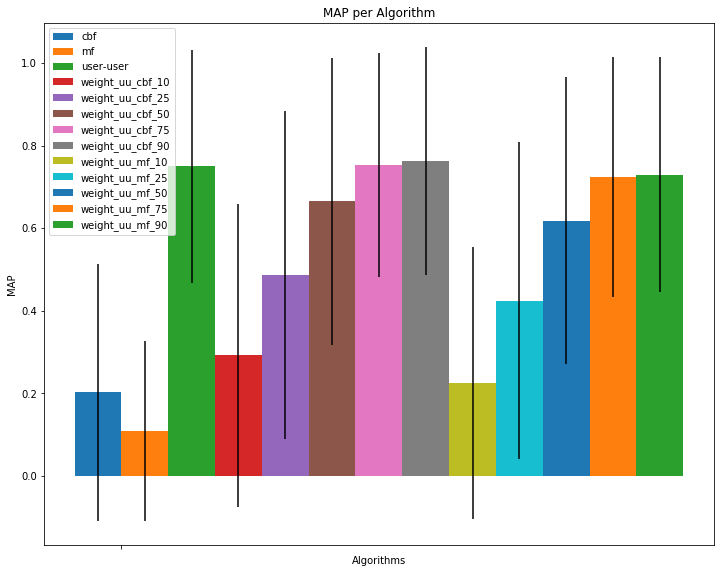

In [8]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [9]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.333333,1.0,1.0,0.202042,0.0,0.310513
mf,0.000000,0.000000,0.000000,0.200000,1.0,1.0,0.109167,0.0,0.218548
user-user,0.332500,0.588889,0.850000,1.000000,1.0,1.0,0.749278,0.0,0.281404
weight_uu_cbf_10,0.000000,0.000000,0.000000,0.500000,1.0,1.0,0.291875,0.0,0.367009
weight_uu_cbf_25,0.000000,0.000000,0.500000,0.879167,1.0,1.0,0.486986,0.0,0.397853
weight_uu_cbf_50,0.000000,0.333333,0.755556,1.000000,1.0,1.0,0.665611,0.0,0.347454
weight_uu_cbf_75,0.333333,0.583333,0.833333,1.000000,1.0,1.0,0.753208,0.0,0.271908
weight_uu_cbf_90,0.333333,0.583333,0.850000,1.000000,1.0,1.0,0.763389,0.0,0.276071
weight_uu_mf_10,0.000000,0.000000,0.000000,0.333333,1.0,1.0,0.225167,0.0,0.328697
weight_uu_mf_25,0.000000,0.000000,0.333333,0.750000,1.0,1.0,0.424722,0.0,0.382984


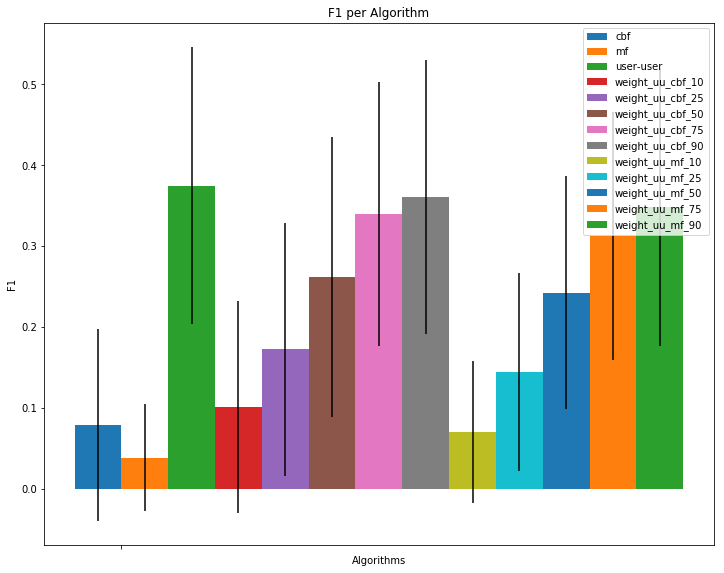

In [10]:
metric = results['F1']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('F1')
ax.set_title('F1 per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()


In [11]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.153846,0.446667,0.666667,0.079245,0.0,0.118720
mf,0.000000,0.000000,0.000000,0.090909,0.200222,0.222222,0.039002,0.0,0.065534
user-user,0.153846,0.246324,0.375000,0.500000,0.728000,0.800000,0.374980,0.0,0.171491
weight_uu_cbf_10,0.000000,0.000000,0.000000,0.166667,0.446667,0.666667,0.101188,0.0,0.131087
weight_uu_cbf_25,0.000000,0.000000,0.153846,0.285714,0.546667,0.666667,0.172532,0.0,0.156399
weight_uu_cbf_50,0.000000,0.142857,0.222222,0.400000,0.615481,0.625000,0.262092,0.0,0.172473
weight_uu_cbf_75,0.142857,0.198387,0.333333,0.461538,0.667273,0.727273,0.339572,0.0,0.163192
weight_uu_cbf_90,0.153846,0.246324,0.350384,0.461538,0.728000,0.800000,0.360601,0.0,0.168832
weight_uu_mf_10,0.000000,0.000000,0.000000,0.153846,0.250833,0.333333,0.070114,0.0,0.087515
weight_uu_mf_25,0.000000,0.000000,0.148352,0.222222,0.444444,0.444444,0.144197,0.0,0.122287


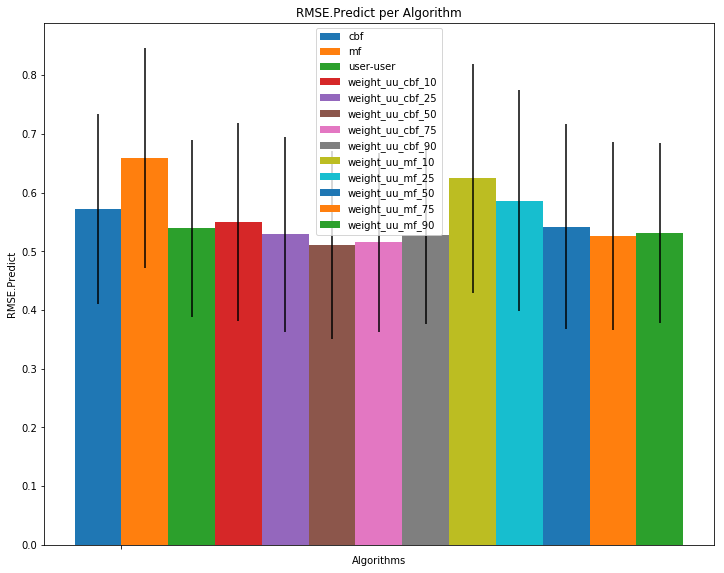

In [12]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [13]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.371323,0.458708,0.565546,0.665676,0.989574,1.017527,0.572387,0.266683,0.161299
mf,0.428535,0.524264,0.638710,0.746580,1.133340,1.258139,0.659029,0.311749,0.187732
user-user,0.379496,0.451870,0.521396,0.608613,0.961865,1.027937,0.539678,0.000000,0.150756
weight_uu_cbf_10,0.352079,0.440935,0.545522,0.646756,0.966068,0.991508,0.550237,0.000000,0.169127
weight_uu_cbf_25,0.324005,0.416156,0.517578,0.619819,0.953484,0.954714,0.529199,0.000000,0.166377
weight_uu_cbf_50,0.316686,0.419193,0.507181,0.602284,0.943110,0.947487,0.511086,0.000000,0.159899
weight_uu_cbf_75,0.347037,0.415115,0.504333,0.610408,0.946087,0.986743,0.515164,0.000000,0.153181
weight_uu_cbf_90,0.362346,0.426711,0.518179,0.601232,0.954046,1.011242,0.527617,0.000000,0.150955
weight_uu_mf_10,0.386468,0.484852,0.607305,0.718027,1.086944,1.230524,0.624257,0.000000,0.194468
weight_uu_mf_25,0.366323,0.454929,0.574988,0.677671,1.020168,1.190717,0.586118,0.000000,0.187915


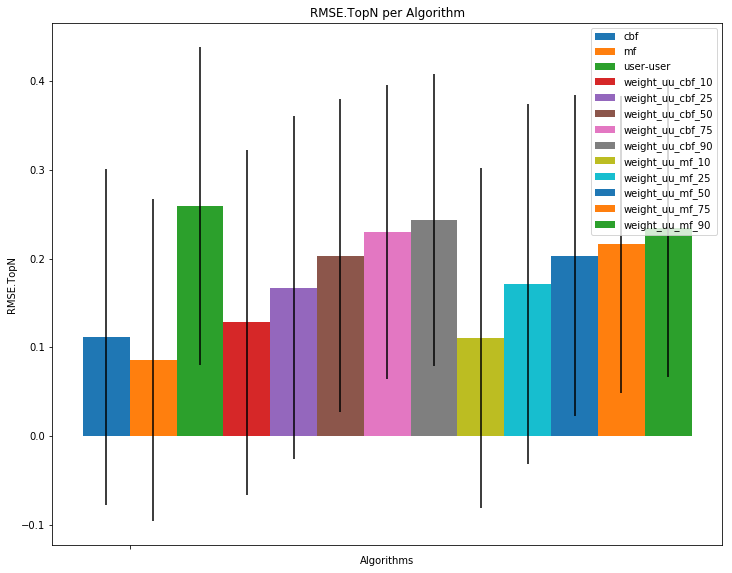

In [14]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [15]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.163600,0.641167,0.811303,0.111610,0.0,0.189255
mf,0.000000,0.000000,0.000000,0.057908,0.670296,0.885882,0.085722,0.0,0.181740
user-user,0.055927,0.117116,0.230005,0.399643,0.680138,0.931245,0.259641,0.0,0.179276
weight_uu_cbf_10,0.000000,0.000000,0.000000,0.174608,0.718819,0.780424,0.127915,0.0,0.194221
weight_uu_cbf_25,0.000000,0.000000,0.108258,0.249863,0.672828,0.824121,0.167251,0.0,0.192946
weight_uu_cbf_50,0.000000,0.064604,0.149062,0.301976,0.636660,0.660800,0.203422,0.0,0.176265
weight_uu_cbf_75,0.053012,0.096370,0.205067,0.332773,0.636868,0.653404,0.230049,0.0,0.165642
weight_uu_cbf_90,0.046579,0.085477,0.224079,0.363072,0.606121,0.615079,0.243501,0.0,0.164427
weight_uu_mf_10,0.000000,0.000000,0.000000,0.165147,0.728077,0.882480,0.110322,0.0,0.191627
weight_uu_mf_25,0.000000,0.000000,0.110328,0.243090,0.669894,0.679231,0.171797,0.0,0.203017


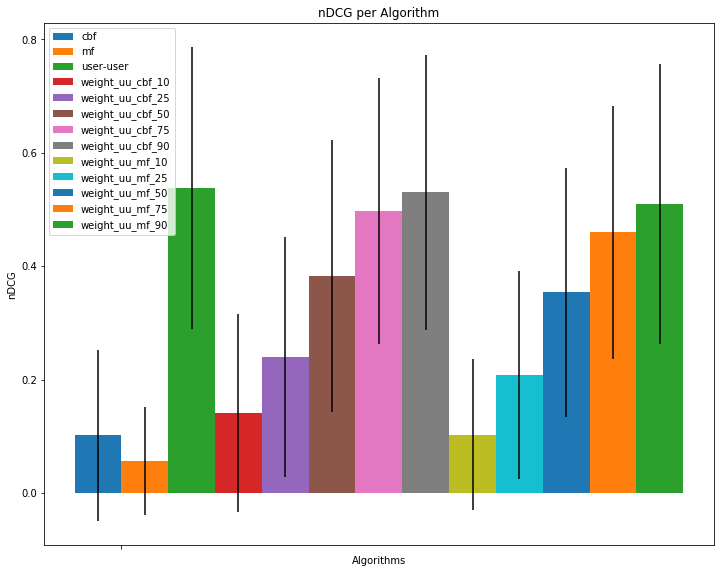

In [16]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [17]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.205765,0.518268,0.757924,0.101620,0.0,0.150979
mf,0.000000,0.000000,0.000000,0.121038,0.363126,0.364263,0.057055,0.0,0.095502
user-user,0.242076,0.363114,0.515847,0.732568,1.000000,1.000000,0.538416,0.0,0.248525
weight_uu_cbf_10,0.000000,0.000000,0.000000,0.242076,0.518268,0.757924,0.140928,0.0,0.173901
weight_uu_cbf_25,0.000000,0.000000,0.242076,0.394809,0.726546,0.757924,0.239793,0.0,0.211304
weight_uu_cbf_50,0.000000,0.242076,0.363114,0.605191,1.000000,1.000000,0.382410,0.0,0.240236
weight_uu_cbf_75,0.193661,0.242076,0.484153,0.726229,1.000000,1.000000,0.497955,0.0,0.234318
weight_uu_cbf_90,0.242076,0.363114,0.484153,0.726229,1.000000,1.000000,0.529915,0.0,0.243014
weight_uu_mf_10,0.000000,0.000000,0.000000,0.242076,0.484153,0.484153,0.103233,0.0,0.133235
weight_uu_mf_25,0.000000,0.000000,0.242076,0.273771,0.726229,0.726229,0.207937,0.0,0.183961


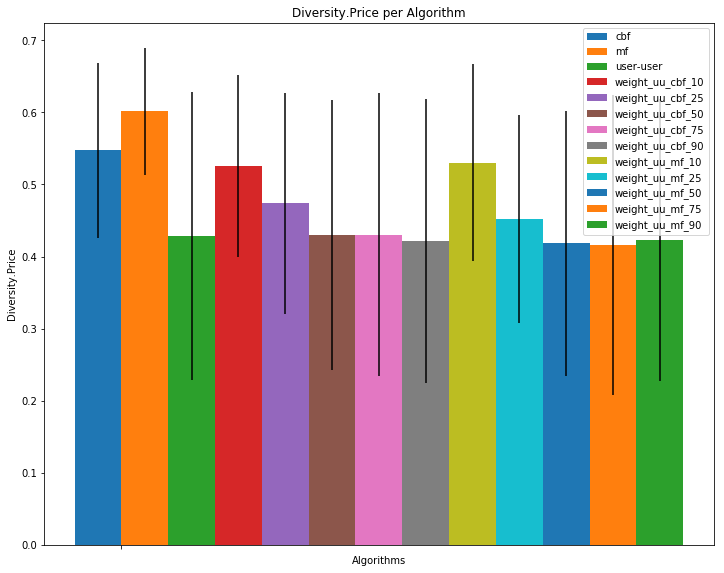

In [18]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [19]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.320,0.48,0.60,0.64,0.72,0.72,0.5472,0.24,0.121178
mf,0.400,0.64,0.64,0.64,0.64,0.64,0.6016,0.40,0.087985
user-user,0.160,0.32,0.48,0.56,0.72,0.72,0.4288,0.00,0.200006
weight_uu_cbf_10,0.320,0.40,0.56,0.64,0.72,0.72,0.5256,0.24,0.126620
weight_uu_cbf_25,0.240,0.40,0.48,0.64,0.72,0.72,0.4736,0.00,0.152915
weight_uu_cbf_50,0.160,0.32,0.40,0.56,0.72,0.72,0.4296,0.00,0.187157
weight_uu_cbf_75,0.160,0.32,0.48,0.56,0.72,0.72,0.4304,0.00,0.196540
weight_uu_cbf_90,0.160,0.30,0.48,0.56,0.72,0.72,0.4216,0.00,0.196889
weight_uu_mf_10,0.320,0.40,0.64,0.64,0.64,0.64,0.5304,0.24,0.136542
weight_uu_mf_25,0.240,0.32,0.40,0.64,0.64,0.64,0.4520,0.16,0.144610


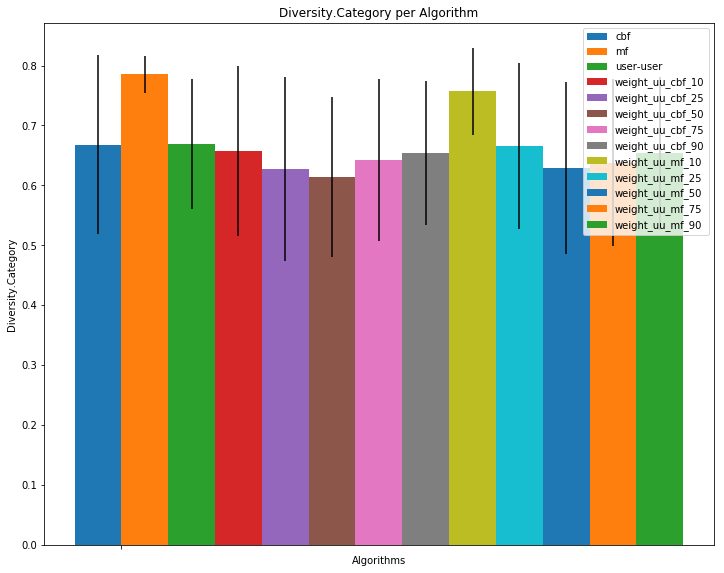

In [20]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [21]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.560,0.64,0.72,0.72,0.8,0.8,0.6680,0.00,0.149399
mf,0.720,0.80,0.80,0.80,0.8,0.8,0.7856,0.72,0.030735
user-user,0.560,0.56,0.72,0.72,0.8,0.8,0.6688,0.32,0.108234
weight_uu_cbf_10,0.480,0.56,0.72,0.72,0.8,0.8,0.6568,0.00,0.141893
weight_uu_cbf_25,0.480,0.56,0.64,0.72,0.8,0.8,0.6272,0.00,0.153350
weight_uu_cbf_50,0.320,0.56,0.64,0.72,0.8,0.8,0.6136,0.32,0.133892
weight_uu_cbf_75,0.552,0.56,0.72,0.72,0.8,0.8,0.6424,0.00,0.135507
weight_uu_cbf_90,0.552,0.56,0.72,0.72,0.8,0.8,0.6544,0.32,0.119936
weight_uu_mf_10,0.640,0.72,0.80,0.80,0.8,0.8,0.7568,0.48,0.072813
weight_uu_mf_25,0.552,0.56,0.72,0.80,0.8,0.8,0.6656,0.00,0.138970


In [22]:
pd.DataFrame.from_dict(results['Coverage.Item'])

,cbf,mf,user-user,weight_uu_cbf_10,weight_uu_cbf_25,weight_uu_cbf_50,weight_uu_cbf_75,weight_uu_cbf_90,weight_uu_mf_10,weight_uu_mf_25,weight_uu_mf_50,weight_uu_mf_75,weight_uu_mf_90
0,0.205,0.045,0.755,0.215,0.275,0.41,0.62,0.695,0.095,0.19,0.35,0.565,0.7


In [23]:
pd.DataFrame.from_dict(results['Coverage.User'])

,cbf,mf,user-user,weight_uu_cbf_10,weight_uu_cbf_25,weight_uu_cbf_50,weight_uu_cbf_75,weight_uu_cbf_90,weight_uu_mf_10,weight_uu_mf_25,weight_uu_mf_50,weight_uu_mf_75,weight_uu_mf_90
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
